This notebook provides a summary of the predictive analyses using task or survey data to predict a set of factors based on demographic/health measures.  

#### Provenance:
- data generated for each run using behav_prediction.py via Singularity container
- multiple runs generated on lonestar5 using singularity_analyses/mk_singularity_script_factor.py
- individual data files combined on ls5 using singularity_analyses/ls5/check_completion.py which generates singularity_analyses/ls5/lasso_data.pkl (which is copied to mac for next step)
- data structures further collapsed using export_data_for_R_factor.py



In [2]:
import os,glob,sys
import pickle
import numpy,pandas
pandas.options.display.max_colwidth = 0
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import seaborn as sns
import scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests
# %load_ext rpy2.ipython
from scipy.cluster.hierarchy import dendrogram,ward,cut_tree,leaves_list
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

import selfregulation.prediction.behavpredict_V1 as behavpredict
from prediction_notebook_utils import get_pval, get_importances,get_importance_list,plotvars

clf='lasso'
acc,features=pickle.load(open('singularity_analyses/ls5/%s_data_collapsed.pkl'%clf,'rb'))
cont_measure='r2' # use r^2 or MAE for non-binary variables

Check all variables to make sure they have the correct number of observations (120), and create tables summarizing data.

In [3]:

allvars={}
datasets=[]
for k in acc.keys():
    if len(acc[k])==0:
        print('no data for',k)
        continue
    datasets.append(k)
    for v in acc[k][cont_measure]['scores_cv']:
        if v=='tmp':
            continue
        allvars[v]=cont_measure
        
alldata={'r2':pandas.DataFrame(),'MAE':pandas.DataFrame(),
        'r2_pval':pandas.DataFrame()}
target_n={}
goodcount={}
for d in datasets:
    if len(acc[k])==0:
        print('no data for',k)
        continue
    
    goodcount[d]={}
    target_n[d]=120
    examplefeature=list(features[d].keys())[0]
    print(d,features[d][examplefeature].shape)

    for v in acc[d]['r2']['scores_cv']:
        if not v in acc[d][allvars[v]]['scores_cv']:
            goodcount[d][v]=0
        else:
            goodcount[d][v]=numpy.isfinite(acc[d][allvars[v]]['scores_cv'][v]).sum()
        if goodcount[d][v]<target_n[d]:
            print(d,v,goodcount[d][v],features[d][v].shape[1])

for v in allvars:
    vars={}
    for k in datasets:
        if not 'r2' in acc[k]:
            continue
        vars[k]=acc[k]['r2']['scores_cv'].mean().T
    df=pandas.DataFrame(vars,index=[v])
    alldata['r2']=alldata['r2'].append(df)

    vars={}
    for k in datasets:
        if not 'MAE' in acc[k]:
            continue
        vars[k]=acc[k]['MAE']['scores_cv'].mean().T
    df=pandas.DataFrame(vars,index=[v])
    alldata['MAE']=alldata['MAE'].append(df)
   


no data for baseline_shuffle
no data for motor_selective_stop_signal
no data for baseline_shuffle_shuffle
no data for motor_selective_stop_signal_shuffle
task (120, 105)
survey (120, 65)
discounting (120, 6)
intelligence (120, 3)
stopping (120, 12)
impulsivity (120, 11)
big5 (120, 5)
risktaking (120, 19)
grit (120, 1)
emotion_regulation (120, 2)
bisbas (120, 4)
thresh (120, 13)
drift (120, 25)
nondecision (120, 13)
stroop (120, 4)
dot_pattern_expectancy (120, 7)
attention_network_task (120, 6)
threebytwo (120, 4)
stop_signal (120, 6)
kirby (120, 3)
discount_titrate (120, 1)
tower_of_london (120, 4)
columbia_card_task_hot (120, 5)
surveyitems (120, 594)
surveyitems MentalIllness 119 594
surveyitems Smoking 119 594
surveyitems Alcohol 119 594
surveyitems Domestic 119 594
surveyitems Obesity 119 594
task_shuffle (120, 105)
survey_shuffle (120, 65)
discounting_shuffle (120, 6)
intelligence_shuffle (120, 3)
stopping_shuffle (120, 12)
impulsivity_shuffle (120, 11)
big5_shuffle (120, 5)
riskt

In [4]:
acc['task']['r2']['scores_cv'].keys()

Index(['DrugUse', 'MentalIllness', 'Smoking', 'Alcohol', 'Domestic',
       'Obesity'],
      dtype='object')

Compute p values

In [5]:


def get_pval(target,null,allvars,datasets,acc,verbose=False):
    data=[]
    vars=[i for i in list(allvars.keys()) if not i=='tmp']
    vars.sort()
    for v in vars:
        if verbose:
            print(target,null,v)
        if not v in acc[target][allvars[v]]['scores_cv'] or not v in acc[null][allvars[v]]['scores_cv']:
            data.append([allvars[v],numpy.nan,numpy.nan,numpy.nan,numpy.nan,numpy.nan])
            continue
        targdist=acc[target][allvars[v]]['scores_cv'][v].dropna()
        targmean=targdist.mean()
        nulldist=acc[null][allvars[v]]['scores_cv'][v].dropna()
        nullmean=nulldist.mean()
        targstd=targdist.std()
        pval=1-scipy.stats.percentileofscore(nulldist,targmean)/100.
        if targstd>0:
            #es=(targmean-nullmean)/targstd
            es=targmean-nullmean
        else:
            es=numpy.nan
        insample=acc[target][allvars[v]]['scores_insample_unbiased'][v].mean()
        data.append([allvars[v],targmean,nullmean,es,insample,pval])
    #newvars=[factor_renaming_dict[i] for i in vars]
    df=pandas.DataFrame(data,index=vars,columns=['Measure','Target mean','Null Mean','Effect size','In-sample','p_unc'])
    return(df)



pvals={}
for d in datasets:
    if d.find('shuffle')>-1 or len(acc[d])==0:
        continue
    print(d)
    pvals[(d,d+'_shuffle')]=get_pval(d,d+'_shuffle',allvars,datasets,acc)

pvals_fdr={}
for k in pvals:
    tmp=multipletests(pvals[k]['p_unc'])
    pvals[k]['p_fdr']=tmp[1]

task
survey
discounting
intelligence
stopping
impulsivity
big5
risktaking
grit
emotion_regulation
bisbas
thresh
drift
nondecision
stroop
dot_pattern_expectancy
attention_network_task
threebytwo
stop_signal
kirby
discount_titrate
tower_of_london
columbia_card_task_hot
surveyitems


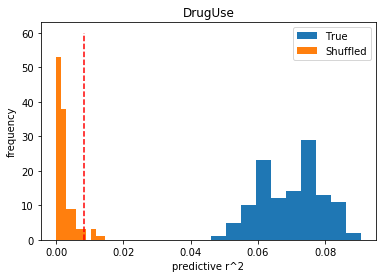

In [6]:
v='DrugUse'
shufacc=acc['survey_shuffle']['r2']['scores_cv'][v]
goodacc=acc['survey']['r2']['scores_cv'][v]
plt.hist(goodacc)
plt.hist(shufacc)
plt.legend(['True','Shuffled'])
plt.xlabel('predictive r^2')
plt.ylabel('frequency')
plt.title(v)
cutoff=scipy.stats.scoreatpercentile(shufacc,95)
plt.plot([cutoff,cutoff],[0,60],'r--')
plt.savefig('nulldist%s.png'%clf,dpi=300)

## Example of overfitting

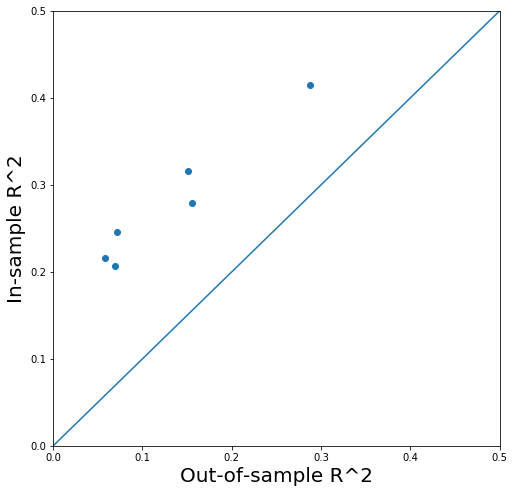

In [7]:
k=('survey','survey_shuffle')
plt.figure(figsize=(8,8))
r2data=pvals[k].query('Measure == "r2"')
plt.scatter(r2data['Target mean'],r2data['In-sample'])
plt.plot([0,1],[0,1])
plt.axis([0,0.5,0,0.5])
plt.xlabel('Out-of-sample R^2',fontsize=20)
plt.ylabel('In-sample R^2',fontsize=20)
plt.savefig('overfitting_factors_%s.png'%clf,dpi=300)

## Show variables with greater prediction for survey vs. baseline

In [8]:
pthresh=0.05
sigp={}
plot_sep_vars=False
k=('survey','survey_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
if plot_sep_vars:
    for v in sigp[k].index:
        plotvars(v,pvals,datasets,allvars)

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
MentalIllness,r2,0.287690,0.002525,0.285164,0.415384,0.0,0.0,"[[time_perspective_survey.past_negative, five_facet_mindfulness_survey.nonjudge, future_time_perspective_survey.future_time_perspective]]"
Alcohol,r2,0.155359,0.002162,0.153198,0.279089,0.0,0.0,"[[sensation_seeking_survey.disinhibition, dospert_rt_survey.health_safety, brief_self_control_survey.self_control]]"
Obesity,r2,0.150928,0.002925,0.148003,0.316139,0.0,0.0,"[[eating_survey.emotional_eating, leisure_time_activity_survey.activity_level, brief_self_control_survey.self_control]]"
Smoking,r2,0.071172,0.002888,0.068284,0.245847,0.0,0.0,"[[dospert_rt_survey.health_safety, sensation_seeking_survey.disinhibition, sensation_seeking_survey.experience_seeking]]"
DrugUse,r2,0.069745,0.002400,0.067346,0.206476,0.0,0.0,"[[upps_impulsivity_survey.positive_urgency, bis11_survey.Motor, sensation_seeking_survey.experience_seeking]]"
Domestic,r2,0.057771,0.002753,0.055018,0.215822,0.0,0.0,"[[time_perspective_survey.past_positive, time_perspective_survey.past_negative, mpq_control_survey.control.ReflogTr]]"


In [9]:
k=('survey','survey_shuffle')
for i in sigp[k].index:
    print(i)
    display(get_importances(i,k[0],features,10))
    print('')

MentalIllness


,importance,mean
time_perspective_survey.past_negative,1.000000,0.229606
five_facet_mindfulness_survey.nonjudge,1.000000,-0.068776
future_time_perspective_survey.future_time_perspective,1.000000,-0.090158
ten_item_personality_survey.emotional_stability,1.000000,-0.165388
dospert_eb_survey.social,0.975000,0.041829
selection_optimization_compensation_survey.optimization.ReflogTr,0.933333,0.036311
dospert_eb_survey.financial,0.891667,0.029734
time_perspective_survey.past_positive,0.883333,-0.026199
eating_survey.emotional_eating,0.708333,0.014655
upps_impulsivity_survey.lack_of_premeditation,0.691667,-0.026721



Alcohol


,importance,mean
sensation_seeking_survey.disinhibition,1.000000,0.188888
dospert_rt_survey.health_safety,1.000000,0.113225
brief_self_control_survey.self_control,0.958333,-0.055247
bis11_survey.Motor,0.950000,0.047939
ten_item_personality_survey.extraversion,0.691667,0.021350
upps_impulsivity_survey.positive_urgency,0.675000,0.017327
dospert_eb_survey.recreational,0.400000,0.006968
dospert_rt_survey.recreational,0.358333,0.005848
dospert_rt_survey.ethical,0.341667,0.007020
eating_survey.cognitive_restraint,0.325000,0.005852



Obesity


,importance,mean
eating_survey.emotional_eating,1.000000,0.208101
leisure_time_activity_survey.activity_level,1.000000,-0.113752
brief_self_control_survey.self_control,1.000000,-0.127392
ten_item_personality_survey.openness,0.941667,-0.056570
eating_survey.uncontrolled_eating,0.933333,0.054779
dospert_eb_survey.recreational,0.916667,-0.036102
bis_bas_survey.BIS,0.841667,-0.067723
erq_survey.suppression,0.766667,-0.038105
dospert_rp_survey.recreational,0.758333,0.032960
eating_survey.cognitive_restraint,0.616667,0.013054



Smoking


,importance,mean
dospert_rt_survey.health_safety,1.000000,0.174066
sensation_seeking_survey.disinhibition,0.991667,0.081964
sensation_seeking_survey.experience_seeking,0.900000,0.035433
dospert_eb_survey.ethical,0.683333,-0.029351
eating_survey.emotional_eating,0.600000,-0.018807
leisure_time_activity_survey.activity_level,0.591667,-0.018475
eating_survey.cognitive_restraint,0.550000,-0.016120
five_facet_mindfulness_survey.describe,0.525000,0.010225
ten_item_personality_survey.extraversion,0.516667,0.014136
upps_impulsivity_survey.lack_of_perseverance,0.491667,-0.014006



DrugUse


,importance,mean
upps_impulsivity_survey.positive_urgency,1.000000,0.118220
bis11_survey.Motor,1.000000,0.091697
sensation_seeking_survey.experience_seeking,0.983333,0.053556
dospert_rt_survey.health_safety,0.733333,0.018732
five_facet_mindfulness_survey.nonjudge,0.525000,-0.010491
dospert_rt_survey.financial,0.391667,0.007465
time_perspective_survey.past_positive,0.316667,-0.004447
dospert_eb_survey.social,0.266667,0.004054
sensation_seeking_survey.thrill_adventure_seeking,0.216667,0.004456
theories_of_willpower_survey.endorse_limited_resource,0.216667,-0.005008



Domestic


,importance,mean
time_perspective_survey.past_positive,1.000000,0.101462
time_perspective_survey.past_negative,1.000000,-0.115097
mpq_control_survey.control.ReflogTr,0.950000,0.090141
leisure_time_activity_survey.activity_level,0.933333,0.047534
eating_survey.cognitive_restraint,0.800000,0.025447
dospert_rt_survey.social,0.725000,-0.022698
sensation_seeking_survey.experience_seeking,0.691667,-0.027299
dospert_rp_survey.financial,0.683333,0.023257
bis_bas_survey.BAS_drive,0.641667,0.019944
five_facet_mindfulness_survey.observe,0.608333,-0.017139


## Show variables with greater prediction for task vs. baseline

In [10]:
k=('task','task_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
if plot_sep_vars:
    for v in sigp[k].index:
        plotvars(v,pvals,datasets,allvars)

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Domestic,r2,0.032583,0.002774,0.029809,0.277126,0.0,0.0,"[[writing_task.neutral_probability, writing_task.positive_probability, simon.hddm_non_decision]]"
Obesity,r2,0.017046,0.002393,0.014653,0.250837,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, stim_selective_stop_signal.hddm_drift, dietary_decision.health_sensitivity]]"


In [11]:
k=('task','task_shuffle')
for i in sigp[k].index:
    print(i)
    display(get_importances(i,k[0],features,10))
    print('')

Domestic


,importance,mean
writing_task.neutral_probability,0.975000,0.076466
writing_task.positive_probability,0.950000,0.055352
simon.hddm_non_decision,0.941667,-0.055987
cognitive_reflection_survey.correct_proportion,0.933333,0.054702
kirby.hyp_discount_rate_large.logTr,0.858333,-0.035260
recent_probes.hddm_drift,0.758333,-0.024909
columbia_card_task_cold.loss_sensitivity,0.733333,-0.022681
directed_forgetting.hddm_drift,0.725000,-0.026153
dot_pattern_expectancy.bias,0.641667,-0.020498
bickel_titrator.hyp_discount_rate_medium.logTr,0.550000,-0.011656



Obesity


,importance,mean
stim_selective_stop_signal.hddm_thresh.logTr,0.933333,-0.044842
stim_selective_stop_signal.hddm_drift,0.908333,-0.037423
dietary_decision.health_sensitivity,0.900000,-0.045265
kirby.hyp_discount_rate_small.logTr,0.850000,0.034760
stroop.hddm_drift,0.775000,-0.024799
angling_risk_task_always_sunny.release_loss_percent,0.633333,-0.020435
recent_probes.hddm_non_decision,0.591667,-0.015308
tower_of_london.num_optimal_solutions,0.516667,0.012121
local_global_letter.hddm_drift,0.458333,-0.011862
columbia_card_task_hot.gain_sensitivity,0.441667,0.011168


### Make figure for paper

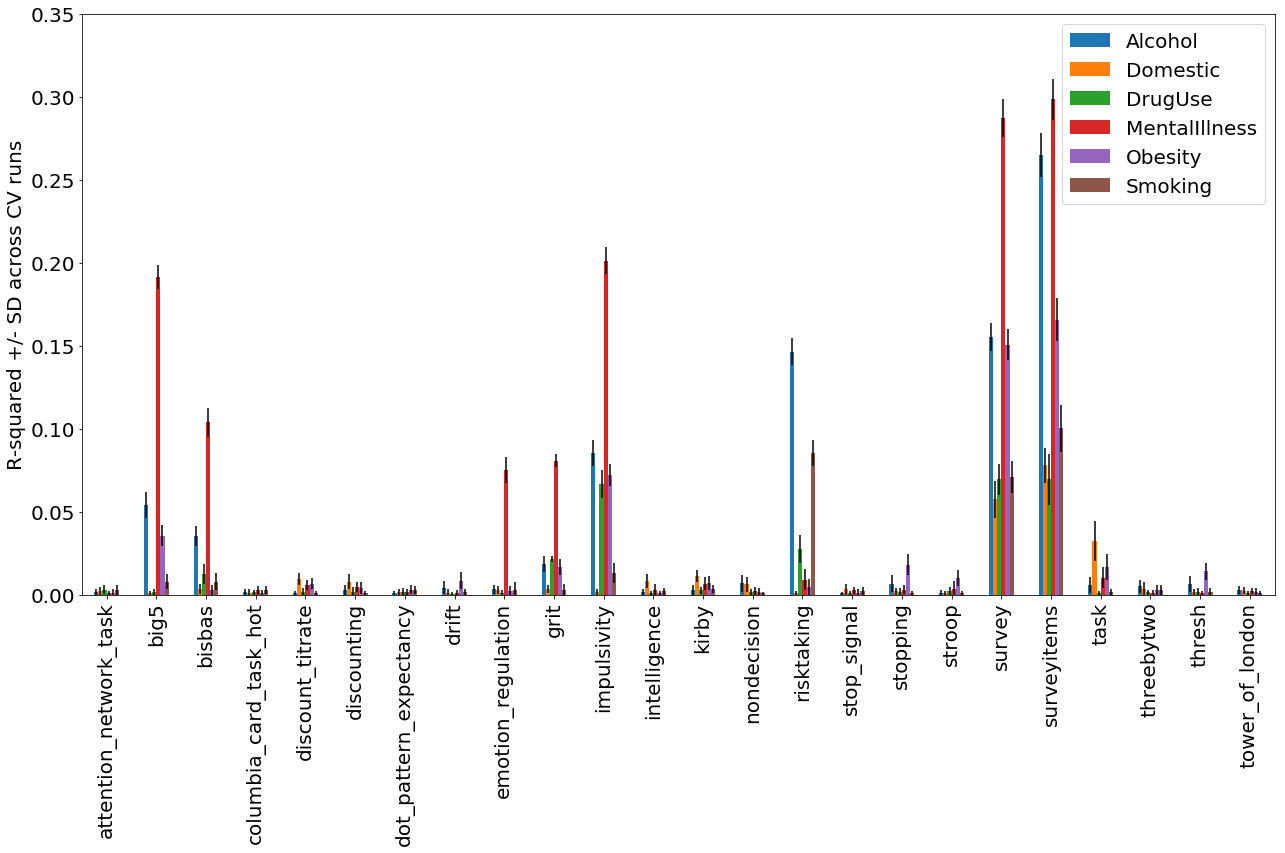

In [62]:

def plot_paper_vars(vars,pvals,datasets,allvars):
    f, axarr = plt.subplots(2, 2,figsize=(18,16))
    xy=[[0,0],[0,1],[1,0],[1,1]]
    ctr=0
    for v in vars:
        df=[]
        errors=[]
        ds=[]
        for k in datasets:
            if not allvars[v] in acc[k]:
                continue
            if not v in acc[k][allvars[v]]['scores_cv']:
                continue
            targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
            df.append(targdist.mean())
            ds.append(k)
            errors.append(targdist.std())
        df=pandas.DataFrame({'mean':df},index=ds)
        errors=pandas.DataFrame({'mean':errors},index=ds)
        if allvars[v]=='AUROC':
            df.plot.bar(yerr=errors,legend=False,
                    ylim=(0.45,numpy.max(df.values)*1.1),
                        ax=axarr[xy[ctr][0],xy[ctr][1]],
                       title=v)
        else:
            df.plot.bar(yerr=errors,legend=False,
                        ax=axarr[xy[ctr][0],xy[ctr][1]],
                       title=v)
        if xy[ctr][0]==0:
            x_axis = axarr[xy[ctr][0],xy[ctr][1]].axes.get_xaxis()
            x_axis.set_visible(False)
        if xy[ctr][1]==0:
            plt.ylabel(allvars[v]+' +/- SE across CV runs')
        ctr+=1
                                                                  
vars=list(pvals[('survey','survey_shuffle')].index)       
vars.sort()
#def plot_paper_vars2(vars,pvals,datasets,allvars):


if 1:
    f= plt.figure(figsize=(18,12))
    ax=plt.gca()
    data=None
    errors=None
    for v in vars:
        df=[]
        err=[]
        ds=[]
        for k in datasets:
            if k.find('_shuffle')>-1:
                continue
            if not allvars[v] in acc[k]:
                continue
            if not v in acc[k][allvars[v]]['scores_cv']:
                continue
            targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
            df.append(targdist.mean())
            ds.append(k)
            err.append(targdist.std())
        if data is None:
            data=pandas.DataFrame({v:df},index=ds)
            errors=pandas.DataFrame({v:err},index=ds)
        else:
            data[v]=pandas.DataFrame({v:df},index=ds)
            errors[v]=pandas.DataFrame({v:err},index=ds)
    data.sort_index(inplace=True)    
    if allvars[v]=='AUROC':
        data.plot.bar(yerr=errors,legend=True,
                ylim=(0.45,numpy.max(df.values)*1.1),
                   title=v,ax=ax,fontsize=20)
    else:
        data.plot.bar(yerr=errors,
                   ax=ax,fontsize=20,ylim=[0,0.35])
    plt.ylabel('R-squared +/- SD across CV runs',fontsize=20)
    plt.legend(fontsize=20)   
    plt.tight_layout(1.25)
data.to_csv('figure_data_%s.csv'%clf)
#plot_paper_vars(figurevars,pvals,datasets,allvars)
plt.savefig('factor_barplots_%s.png'%clf,dpi=300)

### Analysis of survey items

In [63]:
dataset='Complete_10-08-2017'
datadir=os.path.join('../Data/%s'%dataset)
outdir=os.path.join('../Data/Derived_Data/%s'%dataset)
metadata=[]
with open(os.path.join(outdir,'survey_metadata.tsv')) as f:
    for i in f.readlines():
        l_s=i.strip().split('\t')
        metadata.append([l_s[0],' '.join(l_s[1:])])
metadata_df=pandas.DataFrame(metadata,columns=['item','text'])
metadata_df.index=metadata_df.item
metadata_df=metadata_df.drop('item',axis=1)

k=('surveyitems','surveyitems_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    #plotvars(v,pvals,datasets,allvars)
    print(v)
    i=get_importances(v,k[0],features,4) 
    itemtext=[]
    for j in range(i.shape[0]):
        itemtext.append(metadata_df.loc[i.index[j]].text)
    i['text']=itemtext
    print(i )  
    print('')    


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
MentalIllness,r2,0.298766,0.002244,0.296522,1.0,0.0,0.0,"[[time_perspective_survey.34, time_perspective_survey.05, time_perspective_survey.17]]"
Alcohol,r2,0.265109,0.002326,0.262784,1.0,0.0,0.0,"[[dospert_rt_survey.06, sensation_seeking_survey.37, self_regulation_survey.04]]"
Obesity,r2,0.165927,0.002708,0.163219,1.0,0.0,0.0,"[[eating_survey.07, brief_self_control_survey.09, bis_bas_survey.07]]"
Smoking,r2,0.100638,0.002545,0.098094,1.0,0.0,0.0,"[[sensation_seeking_survey.14, time_perspective_survey.23, brief_self_control_survey.05]]"
Domestic,r2,0.078118,0.002832,0.075286,1.0,0.0,0.0,"[[bis_bas_survey.02, time_perspective_survey.23, bis11_survey.17]]"
DrugUse,r2,0.069768,0.002421,0.067347,1.0,0.0,0.0,"[[impulsive_venture_survey.21, upps_impulsivity_survey.16, mpq_control_survey.16]]"


MentalIllness
                                   importance      mean  \
time_perspective_survey.34         1.000000    0.072468   
time_perspective_survey.05         1.000000    0.071810   
time_perspective_survey.17         1.000000    0.068549   
future_time_perspective_survey.04  0.991597   -0.059458   

                                                                                                                                                                                               text  
time_perspective_survey.34         Things rarely work out as I expected. 1:Very uncharacteristic 2: Uncharacteristic 3: Neutral 4: Characteristic 5: Very characteristic                             
time_perspective_survey.05         I often think of what I should have done differently in my life. 1:Very uncharacteristic 2: Uncharacteristic 3: Neutral 4: Characteristic 5: Very characteristic  
time_perspective_survey.17         Painful past experiences keep being replayed in my mind. 1:Ve

## Show variables with greater prediction for DDM parameters vs. baseline

### drift

In [13]:
k=('drift','drift_shuffle')
sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')    


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


### Threshold

In [14]:
k=('thresh','thresh_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    #plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Obesity,r2,0.014326,0.00217,0.012156,0.035808,0.0,0.0,"[[stim_selective_stop_signal.hddm_thresh.logTr, choice_reaction_time.hddm_thresh, stroop.hddm_thresh]]"


Obesity
                                              importance      mean
stim_selective_stop_signal.hddm_thresh.logTr  0.991667   -0.089416
choice_reaction_time.hddm_thresh              0.133333   -0.001957
stroop.hddm_thresh                            0.083333   -0.001476



### Nondecision time

In [15]:
k=('nondecision','nondecision_shuffle')
sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    #plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


## Show variables with greater prediction for intelligence vs. baseline

In [16]:
k=('intelligence','intelligence_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
display(pvals[k])

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr
Alcohol,r2,0.001655,0.003159,-0.001503,0.006788,0.625000,0.947266
Domestic,r2,0.008594,0.002913,0.005681,0.020204,0.066667,0.338971
DrugUse,r2,0.001024,0.002832,-0.001807,0.007835,0.750000,0.947266
MentalIllness,r2,0.003309,0.002567,0.000741,0.001738,0.208333,0.689035
Obesity,r2,0.000972,0.002431,-0.001458,0.009915,0.733333,0.947266
Smoking,r2,0.002206,0.002513,-0.000308,0.004686,0.391667,0.863049


## Show variables with greater prediction for stopping vs. baseline


In [17]:
k=('stopping','stopping_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    #plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Obesity,r2,0.01838,0.002724,0.015657,0.056997,0.008333,0.04897,"[[stim_selective_stop_signal.hddm_thresh.logTr, stim_selective_stop_signal.hddm_drift, stop_signal.proactive_slowing]]"


Obesity
                                              importance      mean
stim_selective_stop_signal.hddm_thresh.logTr  0.966667   -0.073610
stim_selective_stop_signal.hddm_drift         0.958333   -0.069753
stop_signal.proactive_slowing                 0.625000   -0.022273



## Show variables with greater prediction for discounting vs. baseline


In [18]:
k=('discounting','discounting_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
display(pvals[k])

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr
Alcohol,r2,0.003038,0.003451,-0.000413,0.008537,0.283333,0.669295
Domestic,r2,0.008124,0.002816,0.005308,0.027015,0.075000,0.373602
DrugUse,r2,0.001899,0.002518,-0.000620,0.007838,0.450000,0.697500
MentalIllness,r2,0.004911,0.002629,0.002281,0.021179,0.141667,0.534114
Obesity,r2,0.004077,0.003354,0.000723,0.021566,0.241667,0.669295
Smoking,r2,0.001222,0.002541,-0.001319,0.020509,0.583333,0.697500


### Assess survey variables in terms of their overall predictive utility


In [19]:
k=('survey','baseline')
df=pandas.DataFrame()
absfeat=pandas.DataFrame()

for v in features['survey']:
    df[v]=features['survey'][v].mean(0)
    absfeat[v]=(features['survey'][v].abs()>0).mean()
    
mean_imp=df.mean(1)
meanabs_survey=pandas.DataFrame({'meanabs':absfeat.mean(1)}).sort_values(by='meanabs',ascending=False)


In [20]:
df=pandas.DataFrame()
absfeat=pandas.DataFrame()

for v in features['task']:
    df[v]=features['task'][v].mean(0)
    absfeat[v]=(features['task'][v].abs()>0).mean()
    
mean_imp=df.mean(1)
meanabs_task=pandas.DataFrame({'meanabs':absfeat.mean(1)}).sort_values(by='meanabs',ascending=False)


### Plot RF versus lasso predictive accuracies

In [21]:
lasso_acc=pandas.read_csv('figure_data_lasso.csv',index_col=0)
rf_acc=pandas.read_csv('figure_data_rf.csv',index_col=0)
assert list(rf_acc.index)==list(lasso_acc.index)
rf_acc_long=rf_acc.melt()
lasso_acc_long=lasso_acc.melt()
plt.figure(figsize=(8,8))
plt.scatter(rf_acc,lasso_acc)
plt.xlabel('Random forest prediction accuracy (r^2)',fontsize=14)
plt.ylabel('Lasso regression prediction accuracy (r^2)',fontsize=14)

plt.axis('square')
plt.plot([0,0.5],[0,0.5])
print('r=%0.3f'%numpy.corrcoef(rf_acc_long.value,lasso_acc_long.value)[0,1])
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(rf_acc_long['value'][:,numpy.newaxis],lasso_acc_long['value'])
print(lr.coef_)
plt.plot([0,1],[0,lr.coef_[0]])
plt.text(0.025,0.275,'r=%0.3f'%numpy.corrcoef(rf_acc_long.value,lasso_acc_long.value)[0,1],
        fontsize=14)
plt.text(0.025,0.26,'slope=%0.2f'%lr.coef_[0],
        fontsize=14)
plt.savefig('lasso_vs_rf_acc.png',dpi=300)


AssertionError: 

## task-specific prediction analyses - for Aim 2 task selection

In [ ]:
tasks=['attention_network_task', 
       'columbia_card_task_hot', 'discount_titrate', 
       'dot_pattern_expectancy',
       'kirby', 'motor_selective_stop_signal', 'stop_signal', 
       'stroop', 
       'threebytwo', 'tower_of_london']

for t in tasks:
    k=(t,t+'_shuffle')
    if not k in pvals:
        print('skipping',k)
        continue
    sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
    imp=get_importance_list(sigp[k],k[0],features)
    sigp[k]=sigp[k].join(imp)
    display(sigp[k])
    #for v in sigp[k].index:
        #plotvars(v,pvals,datasets,allvars)